# BitCoin USD Price forecasting with TIMEX
In this notebook we will see how to use TIMEX to automatically create a Facebook Prophet prediction model in order to try to forecast the USD price of Bitcoin.

Now, this is just to show the capabilities of TIMEX and to give an example of code employing TIMEX. The assumption here is that the price of Bitcoin is actually predictable, while it may not be the case (or maybe yes?).

In this notebook we will use the data from the website [Cryptodatadownload](http://www.cryptodatadownload.com/data/bitbay/), which release historical data coming from different trading platforms with the license CC BY-NC-SA 4.0.

In particular, we will use the dataset coming from the Gemini exchange (downloadable [here](http://www.cryptodatadownload.com/data/gemini/)): I made two simply changes to the downloaded CSV:
- removed the first line which contained some comments, in order to have a clean CSV file;
- re-ordered the rows from oldest date to new date. We might add an option to automatize this.

The data looks like this, before being re-ordered in crescent orded:

![overview](figures/BitcoinPrice/Bitcoin_Data_Overview.png)

We will focus on two columns: `Date`, which contain the time-stamps of the time-series, and `Close`, which is the closing price of BitCoin for that day.

We will see how to automatize all the ingestion and prediction tasks.

## TIMEX Configuration Dictionary
The most important aspects of TIMEX can be configured with a simple Python dictionary (or, if you prefer, a JSON file which can be loaded at runtime).

For this task, we could use a dictionary similar to this:

In [40]:
param_config = {
  "activity_title": "Bitcoin price forecasting",
  "verbose": "INFO",
  "input_parameters": {
    "source_data_url": "datasets/BitcoinPrice.csv",
    "columns_to_load_from_url": "Date,Close",  # Load only these columns from the dataset
    "datetime_column_name": "Date",  # Elements of this column are parsed as datetime
    "index_column_name": "Date",  # Use this column as index
    "frequency": "D",  # Data has a daily frequency; we could omit this and TIMEX would try to infer it, but if we know this it's better.
  },
  "model_parameters": {
    "test_values": 15,  # Use the last 15 real values of the time-series as test data, to check the performances.
    "delta_training_percentage": 15,  # Training windows are composed of the 15% of the time-series length; more about this later...
    "prediction_lags": 10,  # Predict the next 10 days.
    "possible_transformations" : "none,log_modified",  # Try to use no transformation or a logarithmic one.
    "models": "fbprophet",  # Use models of class Facebook Prophet.
    "main_accuracy_estimator": "mae"  # Use the Mean Absolute Error as main metric to measure accuracy.
  },
  "historical_prediction_parameters": {  
    # Historical predictions iterate the prediction phase in order to check the accuracy on a 
    # longer period. The best predictions for day x are computed using data available only at
    # day x-1. More on this later...
    "initial_index": "2021-02-01",  # Start the historical predictions from this day
    "save_path": "historical_predictions/historical_predictions_bitcoin.pkl"  # Save the historical predictions in this file
  },
  "visualization_parameters": {
    "xcorr_graph_threshold": 0.8,
    "box_plot_frequency": "1W"
  }
}

## Launch TIMEX!
Launching TIMEX is as simple as running few lines of code. Note that this may require a minute or two...

In [41]:
import logging
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger(__name__)

In [42]:
from timexseries.data_ingestion import ingest_timeseries
from timexseries.data_prediction.pipeline import create_timeseries_containers

ingested_dataset = ingest_timeseries(param_config)

INFO:timexseries.data_ingestion:Starting the data ingestion phase.
INFO:timexseries.data_ingestion:Finished the data-ingestion phase. Some stats:
-> Number of rows: 1964
-> Number of columns: 1
-> Column names: ['Close']
-> Number of missing data: [0]


In [43]:
display(ingested_dataset.tail(5))

,Close
Date,
2021-02-17,52068.01
2021-02-18,51241.23
2021-02-19,55761.10
2021-02-20,56541.20
2021-02-21,56929.10


Launch the prediction for every non-index column in the dataset, in this case only `Close`. This will take some time, because it will compute the `historical_predictions`. If will use data day by day, starting from the 2021-02-01, in order to get the best available predictions using the data available to that day. It is useful to check the past performances of the model...

In [8]:
# Remove the eventual saved historical predictions, to recompute them for educational purposes...
import os
try:
    os.remove("historical_predictions/historical_predictions_bitcoin.pkl")
except FileNotFoundError:
    pass


timeseries_containers = create_timeseries_containers(ingested_dataset, param_config)

INFO:timexseries.data_prediction.pipeline:Historical prediction file not found: computing from the start...
INFO:timexseries.data_prediction.pipeline:Starting index: 2021-02-01 00:00:00
INFO:timexseries.data_prediction.pipeline:Final index: 2021-02-21 00:00:00
INFO:timexseries.data_prediction.pipeline:Using data from 2015-10-08 00:00:00 to 2021-02-01 00:00:00 for training...
INFO:timexseries.data_prediction.pipeline:Using model fbprophet...
INFO:timexseries.data_prediction.pipeline:Computing univariate prediction for Close using transformation: none...
INFO:timexseries.data_prediction.models.predictor:Creating a FBProphet model...
INFO:timexseries.data_prediction.models.predictor:Model will use 7 different training sets...
INFO:timexseries.data_prediction.pipeline:Computing univariate prediction for Close using transformation: log_modified...
INFO:timexseries.data_prediction.models.predictor:Creating a FBProphet model...
INFO:timexseries.data_prediction.models.predictor:Model will use 

A TimeSeriesContainer is a container for a single time-series: it contains its raw, real values, the predictions, the historical predictions, etc.

In this case we have one container because the dataset contains one time-series.
Let's inspect this object:

In [44]:
price_container = timeseries_containers[0]

The first attribute of the container is the `timeseries_data`. This contains the data only relative to the container time-series:

In [45]:
timeseries_data = price_container.timeseries_data
display(timeseries_data.head(5))

,Close
Date,
2015-10-08,243.60
2015-10-09,245.51
2015-10-10,246.30
2015-10-11,248.98
2015-10-12,245.75


The second attribute is `models`. This is a dictionary which contains an entry for each employed model (in this case only `fbprophet`). Each entry is an object of type [ModelResult](https://alexmv12.github.io/TIMEX/timexseries/data_prediction/models/predictor.html#timexseries.data_prediction.models.predictor.ModelResult). This, in turns, contains the results and the relevant aspects of that particular model. This can get a bit confusing, so, let's manually inspect that:

In [46]:
timeseries_models_results = price_container.models
print(timeseries_models_results)

{'fbprophet': <timexseries.data_prediction.models.predictor.ModelResult object at 0x7fc18b947c70>}


In [47]:
prophet_results = timeseries_models_results['fbprophet']
print(prophet_results)

Each ModelResult has:
  - a list of [SingleResult](https://alexmv12.github.io/TIMEX/timexseries/data_prediction/models/predictor.html#timexseries.data_prediction.models.predictor.SingleResult) objects, each one containing the prediction and performances obtained using different training sets;
  - a simple dictionary containing some information on the model;
  - the best prediction, in form of DataFrame, which is automatically selected using the best training window (including the data used for validation).

Let's inspect them:

In [48]:
single_results = prophet_results.results
print(single_results)

[<timexseries.data_prediction.models.predictor.SingleResult object at 0x7fc18b88c3a0>, <timexseries.data_prediction.models.predictor.SingleResult object at 0x7fc18b88c130>, <timexseries.data_prediction.models.predictor.SingleResult object at 0x7fc192cd56a0>, <timexseries.data_prediction.models.predictor.SingleResult object at 0x7fc192cd5520>, <timexseries.data_prediction.models.predictor.SingleResult object at 0x7fc192cd5ac0>, <timexseries.data_prediction.models.predictor.SingleResult object at 0x7fc18b8cc400>, <timexseries.data_prediction.models.predictor.SingleResult object at 0x7fc18b8ccb20>]


If you remember, we specified a `delta_training_percentage` of 15%. This means that, excluding the validation set, TIMEX used these training windows:

```
Train set 1: <       --15%-><validation set>
Train set 2: <      ---30%-><validation set>
Train set 3: <     ----45%-><validation set>
Train set 4: <   ------60%-><validation set>
Train set 5: <  -------75%-><validation set>
Train set 6: < --------90%-><validation set>
Train set 7: <--------100%-><validation set>
```

Each SingleResult corresponds to a sub-training-set.

In [49]:
result_1 = single_results[0]  # This corresponds to the training window which starts from 2020-04-18. 
# `single_results` is ordered from the best training window to the worse.
print(result_1.prediction['yhat'])

ds
2020-04-18     7175.771408
2020-04-19     7233.005472
2020-04-20     7294.573765
2020-04-21     7382.035907
2020-04-22     7552.026263
                  ...     
2021-02-27    53226.124338
2021-02-28    53602.338953
2021-03-01    54009.920932
2021-03-02    54608.252239
2021-03-03    55815.341071
Name: yhat, Length: 320, dtype: float64


In [50]:
print(result_1.testing_performances.get_dict())

{'first_used_index': numpy.datetime64('2020-04-18T00:00:00.000000000'), 'MSE': 20032982.309605822, 'RMSE': 4475.821970276054, 'MAE': 4069.461588155596, 'AM': 3546.8917071967303}


The training set of the `SingleResult` with the lower MAE has been used to create the `best_prediction`.  
Now, for the rest of `ModelResult`:

In [51]:
print(prophet_results.characteristics)

{'name': 'FBProphet', 'delta_training_percentage': 15, 'delta_training_values': 295, 'test_values': 15, 'transformation': <timexseries.data_prediction.transformation.LogModified object at 0x7fc192afcbb0>}


It's interesting to note that the logarithmic transformation has been selected. This means that the MAE is lower when using it.

In [52]:
best_prediction = prophet_results.best_prediction['yhat']
print(best_prediction)

ds
2020-04-18     7181.965196
2020-04-19     7220.278121
2020-04-20     7300.939342
2020-04-21     7384.305949
2020-04-22     7551.855636
                  ...     
2021-02-27    54757.769066
2021-02-28    54999.704052
2021-03-01    55563.403972
2021-03-02    56146.599430
2021-03-03    57368.114614
Name: yhat, Length: 320, dtype: float64


That's it. `best_prediction` is the best forecast obtained by Facebook Prophet in terms of MAE.
We may plot this using TIMEX built-in visualization functions or use whatever plotting library you like (in the end, the results are simple Pandas DataFrames):

In [53]:
from timexseries.data_visualization.functions import line_plot, prediction_plot

prediction_plot = prediction_plot(timeseries_containers[0].timeseries_data, timeseries_containers[0].models["fbprophet"].best_prediction, 1)

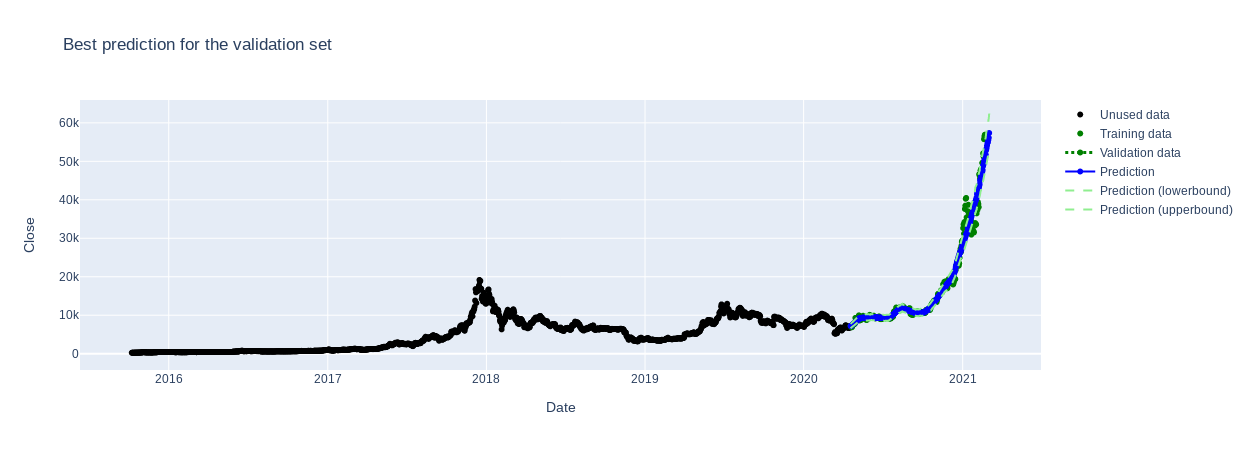

In [54]:
prediction_plot.figure
# Please, ignore `validation_data`. In this context it is useless.

If you focus the last points, you will see the predictions for the next 10 days in the `yhat` trace. 

If you remember, we computed also the `historical_predictions`: let's check this out...

In [55]:
from timexseries.data_visualization.functions import historical_prediction_plot

historical_plot = historical_prediction_plot(timeseries_containers[0].timeseries_data, 
                                             timeseries_containers[0].historical_prediction['fbprophet'],
                                             timeseries_containers[0].models["fbprophet"].best_prediction)

To render correctly this, you would need a Dash app. 

Below you find the code to run this using JupyterDash; however, if you don't feel like installing JupyterDash, here is the result you would obtain:
![historical_plot](figures/BitcoinPrice/Bitcoin_Historical_Plot.png)

The historical predictions are computed step-by-step, starting from a certain date, using only the data available to that date.
For example, if we start from 2021-02-01, then the prediction for 2021-02-02 is computed using the data available to 2021-02-01; to compute the predictions for 2021-02-03 you would use the data available to the 2021-02-02, etc.
This way you can have a real-world estimate of the performances of the prediction model.

More comments in the Results section.

## Website creation

In this section we will see how to build a simple Dash application which shows, in a graphical way, all the results we obtained in this notebook.
Note that to run in the Notebook you need the Jupyter-Dash extension. Otherwise, simply copy the code and run it in a Python script (rembember to change "JupyterDash" to "Dash", when creating `app`!)

In [39]:
# Imports
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from timexseries.data_visualization.functions import create_timeseries_dash_children
from jupyter_dash import JupyterDash

import dash_core_components as dcc
from dash.dependencies import Input, Output

# Data visualization
children_for_each_timeseries = [{
    'name': s.timeseries_data.columns[0],
    'children': create_timeseries_dash_children(s, param_config)
} for s in timeseries_containers]  # This creates the Dash children, for each time-series in the dataset (in this case just one!)

# Initialize Dash app.
app = JupyterDash(__name__)
# app = dash.Dash(__name__) Use this outside of Jupyter!

server = app.server

disclaimer = [html.Div([
    html.H1("Bitcoin price: monitoring and forecasting", style={'text-align': 'center'}),
    html.Hr(),
    html.H4(
        "Dashboard by the Intelligent Embedded Systems (IES) research group of the Politecnico di Milano, Italy",
        style={'text-align': 'center', 'top-margin': '25px'}),
    html.Hr(),
    dcc.Markdown('''
        *Welcome to the monitoring and forecasting dashboard of the Bitcoin USD/BTC price!*
        '''),
    html.Br(),
    html.H2("Please select the data of interest:")
    ], style={'width': '80%', 'margin': 'auto'}
    ), 
dcc.Dropdown(
    id='timeseries_selector',
    options=[{'label': i['name'], 'value': i['name']} for i in children_for_each_timeseries],
    value='Time-series'
), html.Div(id="timeseries_wrapper"), html.Div(dcc.Graph(), style={'display': 'none'})]
tree = html.Div(children=disclaimer, style={'width': '80%', 'margin': 'auto'})

app.layout = tree


@app.callback(
    Output(component_id='timeseries_wrapper', component_property='children'),
    [Input(component_id='timeseries_selector', component_property='value')]
)
def update_timeseries_wrapper(input_value):
    try:
        children = next(x['children'] for x in children_for_each_timeseries if x['name'] == input_value)
    except StopIteration:
        return html.Div(style={'padding': 200})

    return children

app.run_server(port=10000)

Dash app running on http://127.0.0.1:10000/


## Comment on the results

There is an interesting comment to do on the performances of the different training windows. In the webpage, you will find this plot:

![Bitcoin performance plot](figures/BitcoinPrice/Bitcoin_Performance_Plot.png)

This is the plot which shows the obtained error metrics using different training windows.
The highlighted one (April (18), 2020) is the smaller one: it comprises the values from April 18 2020 to February 21 2021. 

However, while being the smaller window, it gives the model the best performances in terms of accuracy: this is an indicator that the underlying process generating the time-series is having a drastic change, in the very recent days. I am looking at you, Elon...


For what concerns the historical prediction, let's focus on the period we tried to forecast:
![Historical detail](figures/BitcoinPrice/Bitcoin_Historical_Plot_Detail.png)

As you see, the started the forecast from the February 1, 2021. We tried to forecast the first 15 days, using a sliding window on the available data.
The prediction were not that bad: we obtained a MAE of 4100.77, however the price is really exploding.
From what we see, it is expected that the price will go up very fast.

However, the process generating the time-series is expected to change at any moment. We saw that even a Tweet can drastically impact the life of Bitcoin, as well as other currencies, stocks, indexes, etc. So, the predictions should not be trusted that much. 